In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.metrics import r2_score

import jax
import jax.numpy as jnp

from picard import amari_distance

from multiviewica_delay import (
    _apply_continuous_delays,
    generate_data,
    data_generation,
    data_generation_pierre,
    multiviewica_delay,
)

from lbfgsb_mul_seeds import optimize_unmixing_delays

### parameters

In [2]:
# params
m = 5
p = 2
n = 600
max_delay = 10
shared_delays = False
random_state = 42
generation_function = "first"
if generation_function == "first":
    nb_intervals = 5
    nb_freqs = 10
    treshold = 1
    noise = 0.8
elif generation_function == "second":
    n_concat = 1
    noise = 0.01
else:
    n_bins = 10
    n_samples_per_interval = n // n_bins
    freq_level = 40
    noise = 0.2

### generate data

In [3]:
# generate sources
if generation_function == "first":
    X_list, A_list, true_tau_list, S_list, S = generate_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        treshold=treshold,
        delay=max_delay,
        noise=noise,
        random_state=random_state,
        shared_delays=shared_delays
    )
elif generation_function == "second":
    X_list, A_list, true_tau_list, S_list, S = data_generation(
        m=m,
        p=p,
        n=n,
        max_delay=max_delay,
        noise=noise,
        shared_delays=shared_delays,
        random_state=random_state,
        n_concat=n_concat,
    )
else:
    X_list, A_list, true_tau_list, S_list, S = data_generation_pierre(
        n_subjects=m,
        n_sources=p,
        n_bins=n_bins,
        n_samples_per_interval=n_samples_per_interval,
        freq_level=freq_level,
        max_delay=max_delay,
        noise=noise,
        shared_delays=shared_delays,
        random_state=random_state,
    )

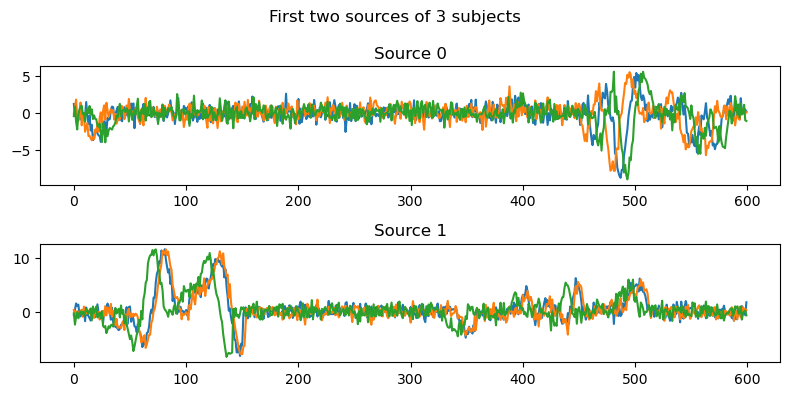

In [4]:
# plot sources of the first 2 subjects
fig, axes = plt.subplots(p, 1, figsize=(4*p, 4))

bound_min = 0
bound_max = n
for i in range(p):
    plt.subplot(p, 1, i+1)
    plt.plot(np.arange(bound_min, bound_max), S_list[:3, i, bound_min:bound_max].T)
    plt.title(f"Source {i}")
fig.suptitle("First two sources of 3 subjects")
plt.tight_layout()

In [5]:
# initialize W_list, S_list and delays
W_list_true = jnp.array([jnp.linalg.inv(A) for A in A_list])
W_list_noise = jax.random.normal(jax.random.PRNGKey(random_state), (m, p, p))
W_list_init = W_list_true + 0.1 * W_list_noise
if shared_delays:
    delays_init = jnp.zeros(m)
else:
    delays_init = jnp.zeros((m, p))

### line profiler

In [6]:
# # cell to be removed
# import time
# import jaxopt

# def _logcosh(X):
#     Y = jnp.abs(X)
#     return Y + jnp.log1p(jnp.exp(-2 * Y))

# def optimize_unmixing_delays(
#     W_list,
#     delays,
#     X_list,
#     max_delay=10,
#     noise=1,
#     shared_delays=False,
#     maxiter=1000,
#     verbose=False,
# ):
#     if verbose:
#         start = time.time()
#     m, p, _ = W_list.shape

#     def loss_function(W_delays):
#         W_list, delays = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:]
#         if not shared_delays:
#             delays = delays.reshape((m, p))
#         S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
#         Y_list = _apply_continuous_delays(
#             S_list=S_list,
#             tau_list=-delays,
#             shared_delays=shared_delays,
#             multiple_subjects=True,
#             use_jax=True,
#         )
#         Y_avg = jnp.mean(Y_list, axis=0)
#         loss = jnp.mean(_logcosh(Y_avg)) * p
#         for W, Y in zip(W_list, Y_list):
#             loss -= jnp.linalg.slogdet(W)[1]
#             loss += 1 / (2 * noise) * jnp.mean((Y - Y_avg) ** 2) * p
#         return loss

#     init_params = jnp.concatenate([jnp.ravel(W_list), jnp.ravel(delays)])
#     bounds_W_bias = (
#         -np.ones_like(init_params) * np.inf,
#         np.ones_like(init_params) * np.inf)
#     if shared_delays:
#         bounds_W_bias[0][-m:] = -max_delay
#         bounds_W_bias[1][-m:] = max_delay
#     else:
#         bounds_W_bias[0][-m*p:] = -max_delay
#         bounds_W_bias[1][-m*p:] = max_delay
#     solver = jaxopt.LBFGSB(fun=loss_function, maxiter=maxiter)
#     res = solver.run(init_params, bounds=bounds_W_bias)
#     params, state = res
#     W_list_final, delays_final = params[:m*p**2].reshape((m, p, p)), params[m*p**2:]
#     if not shared_delays:
#         delays_final = delays_final.reshape((m, p))
#     if verbose:
#         end = time.time()
#         computation_time = end - start
#         return W_list_final, delays_final, state, computation_time
#     return W_list_final, delays_final

In [7]:
# execute only once
# %load_ext line_profiler

In [8]:
# line profiler (might take a lot of time)
# %lprun -f optimize_unmixing_delays optimize_unmixing_delays(W_list=W_list_init, delays=delays_init, X_list=X_list, noise=1, shared_delays=shared_delays, max_delay=max_delay, maxiter=100, verbose=True)

### L-BFGS-B

In [9]:
# takes approximately 1m20 for m=5, p=2, n=600
W_lbfgsb, delays_lbfgsb, state_lbfgsb, time_lbfgsb = optimize_unmixing_delays(
    W_list=W_list_init,
    delays=delays_init,
    X_list=X_list,
    noise=1,
    shared_delays=shared_delays,
    max_delay=max_delay,
    maxiter=1000,
    verbose=True,
)
# problem with maxiter: almost no effect at all on time (although there is an effect on Amari distance)

In [11]:
# compute sources
S_list_lbfgsb = np.array([np.dot(W, X) for W, X in zip(W_lbfgsb, X_list)])
Y_list_lbfgsb = _apply_continuous_delays(
    S_list=S_list_lbfgsb,
    tau_list=-delays_lbfgsb,
    shared_delays=shared_delays,
    multiple_subjects=True,
    use_jax=True,
)
Y_lbfgsb = np.mean(Y_list_lbfgsb, axis=0)

### MVICAD

In [12]:
# MVICAD
_, W_mvicad, Y_mvicad, _, delays_mvicad, _ = multiviewica_delay(
    X_list,
    init=np.array(W_list_init),
    shared_delays=shared_delays,
    max_delay=max_delay,
    random_state=random_state,
    continuous_delays=False,
)
delays_mvicad[delays_mvicad > n // 2] -= n

### scatter plot delays

In [13]:
# estimated sources are not necessarily in the same order as true sources
def find_order(S1, S2):
    S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)
    S2 = S2 / np.linalg.norm(S2, axis=1, keepdims=True)
    M = np.abs(np.dot(S1, S2.T))
    try:
        _, order = scipy.optimize.linear_sum_assignment(-abs(M))
    except:
        order = np.arange(p)
    return order

# change sources order
if not shared_delays:
    order_lbfgsb = find_order(S, Y_lbfgsb)
    delays_lbfgsb = delays_lbfgsb[:, order_lbfgsb]
    order_mvicad = find_order(S, Y_mvicad)
    delays_mvicad = delays_mvicad[:, order_mvicad]

# normalize
delays_mvicad_norm = delays_mvicad - np.mean(delays_mvicad, axis=0)
delays_lbfgsb_norm = delays_lbfgsb - np.mean(delays_lbfgsb, axis=0)
true_tau_list_norm = true_tau_list - np.mean(true_tau_list, axis=0)

In [14]:
def get_fitline(true_delays, delays):
    # Linear regression
    slope, intercept, _, _, _ = stats.linregress(true_delays.ravel(), delays.ravel())
    fitLine = slope * true_delays.ravel() + intercept

    # R2 score
    r2 = r2_score(delays.ravel(), fitLine)

    # p-value
    pvalue = stats.pearsonr(true_delays.ravel(), delays.ravel())[1]
    
    return slope, intercept, fitLine, r2, pvalue

slope_lbfgsb, intercept_lbfgsb, fitLine_lbfgsb, r2_lbfgsb, pvalue_lbfgsb = get_fitline(true_tau_list_norm, delays_lbfgsb_norm)
slope_mvicad, intercept_mvicad, fitLine_mvicad, r2_mvicad, pvalue_mvicad = get_fitline(true_tau_list_norm, delays_lbfgsb_norm)

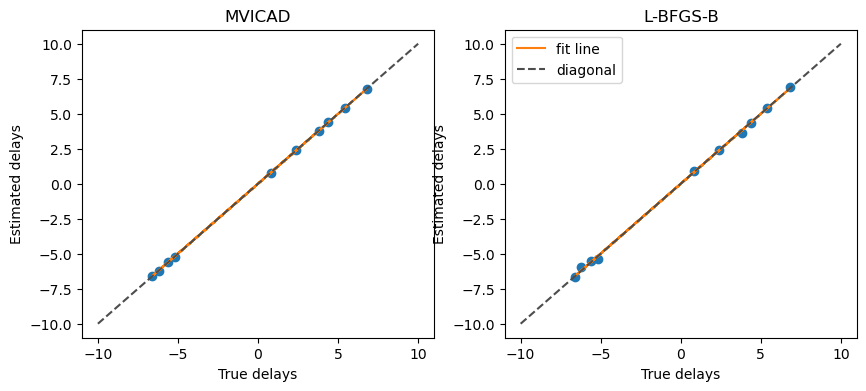

In [15]:
# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# plot: compare estimated and true delays
plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(true_tau_list_norm, delays_mvicad_norm)
plt.plot(true_tau_list_norm.ravel(), fitLine_mvicad, c=colors[1], label='fit line')
plt.plot([-max_delay, max_delay], [-max_delay, max_delay], ls="--", c=".3", label='diagonal')
plt.xlabel("True delays")
plt.ylabel("Estimated delays")
plt.title(f"MVICAD");

plt.subplot(1, 2, 2)
plt.scatter(true_tau_list_norm, delays_lbfgsb_norm)
plt.plot(true_tau_list_norm.ravel(), fitLine_lbfgsb, c=colors[1], label='fit line')
plt.plot([-max_delay, max_delay], [-max_delay, max_delay], ls="--", c=".3", label='diagonal')
plt.legend()
plt.xlabel("True delays")
plt.ylabel("Estimated delays")
plt.title(f"L-BFGS-B");

### compare Amari distance

In [54]:
# random W
W_rand = np.random.randn(m, p, p)

# compare Amari distances
print("Random : ", np.mean([amari_distance(W, A) for W, A in zip(W_rand, A_list)]))
print("L-BFGS-B : ", np.mean([amari_distance(W, A) for W, A in zip(W_lbfgsb, A_list)]))
print("MVICAD : ", np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)]))

Random :  0.609856725933699
L-BFGS-B :  0.001660965127392558
MVICAD :  0.0011761108053653852


### L-BFGS-B separately

In [15]:
# import time
# import jaxopt

# def _logcosh(X):
#     Y = jnp.abs(X)
#     return Y + jnp.log1p(jnp.exp(-2 * Y))

# def optimize_unmixing_delays_separately(
#     W_list,
#     delays,
#     X_list,
#     max_delay=10,
#     noise=1,
#     shared_delays=False,
#     n_iter_outerloop=10,
#     maxiter_W=100,
#     maxiter_delays=20,
#     verbose=False,
# ):
#     if verbose:
#         start = time.time()
#     m, p, _ = W_list.shape

#     def loss_function_W(W_list):
#         W_list = W_list.reshape((m, p, p))
#         S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
#         Y_list = _apply_continuous_delays(
#             S_list=S_list,
#             tau_list=-delays,
#             shared_delays=shared_delays,
#             multiple_subjects=True,
#             use_jax=True,
#         )
#         Y_avg = jnp.mean(Y_list, axis=0)
#         loss = jnp.mean(_logcosh(Y_avg)) * p
#         for W, Y in zip(W_list, Y_list):
#             loss -= jnp.linalg.slogdet(W)[1]
#             loss += 1 / (2 * noise) * jnp.mean((Y - Y_avg) ** 2) * p
#         return loss

#     def loss_function_delays(delays):
#         if not shared_delays:
#             delays = delays.reshape((m, p))
#         Y_list = _apply_continuous_delays(
#             S_list=S_list,
#             tau_list=-delays,
#             shared_delays=shared_delays,
#             multiple_subjects=True,
#             use_jax=True,
#         )
#         Y_avg = jnp.mean(Y_list, axis=0)
#         loss = jnp.mean(_logcosh(Y_avg)) * p
#         for W, Y in zip(W_list, Y_list):
#             loss -= jnp.linalg.slogdet(W)[1]
#             loss += 1 / (2 * noise) * jnp.mean((Y - Y_avg) ** 2) * p
#         return loss
    
#     solver_W = jaxopt.LBFGS(fun=loss_function_W, maxiter=maxiter_W)
#     solver_delays = jaxopt.LBFGSB(fun=loss_function_delays, maxiter=maxiter_delays)
#     bounds_delays = (
#         -np.ones_like(delays) * max_delay,
#         np.ones_like(delays) * max_delay)
#     for _ in range(n_iter_outerloop):
#         W_list = jnp.ravel(W_list)
#         W_list, _ = solver_W.run(W_list)
#         W_list = W_list.reshape((m, p, p))
#         S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
#         if not shared_delays:
#             delays = jnp.ravel(delays)
#         print(len(delays))
#         delays, _ = solver_delays.run(delays, bounds=bounds_delays)
#         if not shared_delays:
#             delays = delays.reshape((m, p))

#     if verbose:
#         end = time.time()
#         computation_time = end - start
#         return W_list, delays, computation_time
#     return W_list, delays

In [16]:
# # might take time
# n_iter_outerloop = 10
# maxiter_W = 100
# maxiter_delays = 20

# W_lbfgsb_sep, delays_lbfgsb_sep, time_lbfgsb_sep = optimize_unmixing_delays_separately(
#     W_list=W_list_init,
#     delays=delays_init,
#     X_list=X_list,
#     noise=1,
#     shared_delays=shared_delays,
#     max_delay=max_delay,
#     n_iter_outerloop=n_iter_outerloop,
#     maxiter_W=maxiter_W,
#     maxiter_delays=maxiter_delays,
#     verbose=True,
# )

10


ValueError: Incompatible shapes for broadcasting: shapes=[(5, 2), (10,)]